#  Standalone DIP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets as dtsets
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import math

## Set Random Seed

In [2]:
def set_seed(seed=2400, loader=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

In [3]:
set_seed(seed=2400, loader=None)

## Load Data

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 64

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def save_tensor_image(tensor, filename):
    tensor = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(tensor)
    image.save(filename)

In [7]:
def show_tensor_image(image):
    '''
    Plots image after applying reverse transformations.
    '''
    image = image.detach().cpu()
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

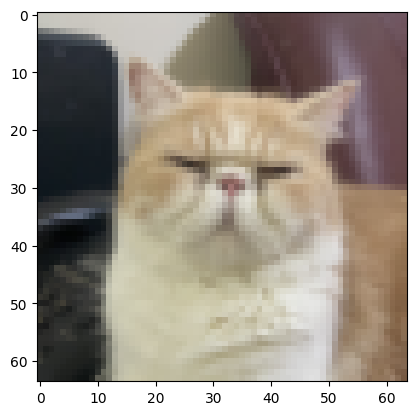

In [8]:
data = load_image("./data/mycat.jpg")
show_tensor_image(data)

In [9]:
from skimage.metrics import structural_similarity as ssim

def get_ssim(img1, img2):
    img1 = img1.detach().to('cpu').numpy()
    img2 = img2.detach().to('cpu').numpy()

    img1 = np.transpose(img1.squeeze(), (1, 2, 0))
    img2 = np.transpose(img2.squeeze(), (1, 2, 0))
    
    # calculate SSIM for each channel
    ssim_score, _ = ssim(img1, img2, win_size=3, multichannel=True, full=True, data_range=1.0)
    return ssim_score

## DIP training

In [10]:
# U-Net
class DIP_Model(nn.Module):
    def __init__(self):
        super(DIP_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
def train_dip(target_image, num_iterations=1000, save_every=100, print_info=True):
    DIP_model = DIP_Model().to(device)
    optimizer = optim.Adam(DIP_model.parameters(), lr=5e-4)
    criterion = nn.MSELoss()

    target_image = target_image.to(device)
    
    # random noise
    input_noise = torch.randn_like(target_image).to(device)

    start = time.time()
    total_time = 0

    loss_history = []
    ssim_history = []
    imgs = []

    for i in range(num_iterations):

        optimizer.zero_grad()
        output = DIP_model(input_noise)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        score = get_ssim(output, target_image)
        ssim_history.append(score)

        if i % save_every == 0:
            end = time.time()
            total_time = total_time + (end-start)
            imgs.append(output)
            if print_info:
                print(f'Iteration {i:d}:')
                print(f'Loss={loss.item():<.6f}, Total Spent time={total_time:<.4f}(s), SSIM={score:<-4f}')
                print("---------------------------------------------------------")
            start = time.time()
            
    if print_info:
            print(f'Total Spent time={total_time:-.4f}(s)')
    imgs.append(output)
    
    return loss_history, ssim_history, imgs, total_time

In [24]:
num_iterations = 2000
save_every = 100
loss_history, ssim_history, result, total_time = train_dip(data, num_iterations, save_every, print_info=True)

Iteration 0:
Loss=0.444732, Total Spent time=0.0076(s), SSIM=0.044570
---------------------------------------------------------
Iteration 100:
Loss=0.218108, Total Spent time=0.5429(s), SSIM=0.000668
---------------------------------------------------------
Iteration 200:
Loss=0.216048, Total Spent time=1.0661(s), SSIM=0.001254
---------------------------------------------------------
Iteration 300:
Loss=0.214005, Total Spent time=1.5963(s), SSIM=0.002327
---------------------------------------------------------
Iteration 400:
Loss=0.210877, Total Spent time=2.1205(s), SSIM=0.005270
---------------------------------------------------------
Iteration 500:
Loss=0.203459, Total Spent time=2.6286(s), SSIM=0.022916
---------------------------------------------------------
Iteration 600:
Loss=0.115892, Total Spent time=3.1321(s), SSIM=0.446262
---------------------------------------------------------
Iteration 700:
Loss=0.112952, Total Spent time=3.6361(s), SSIM=0.491349
--------------------

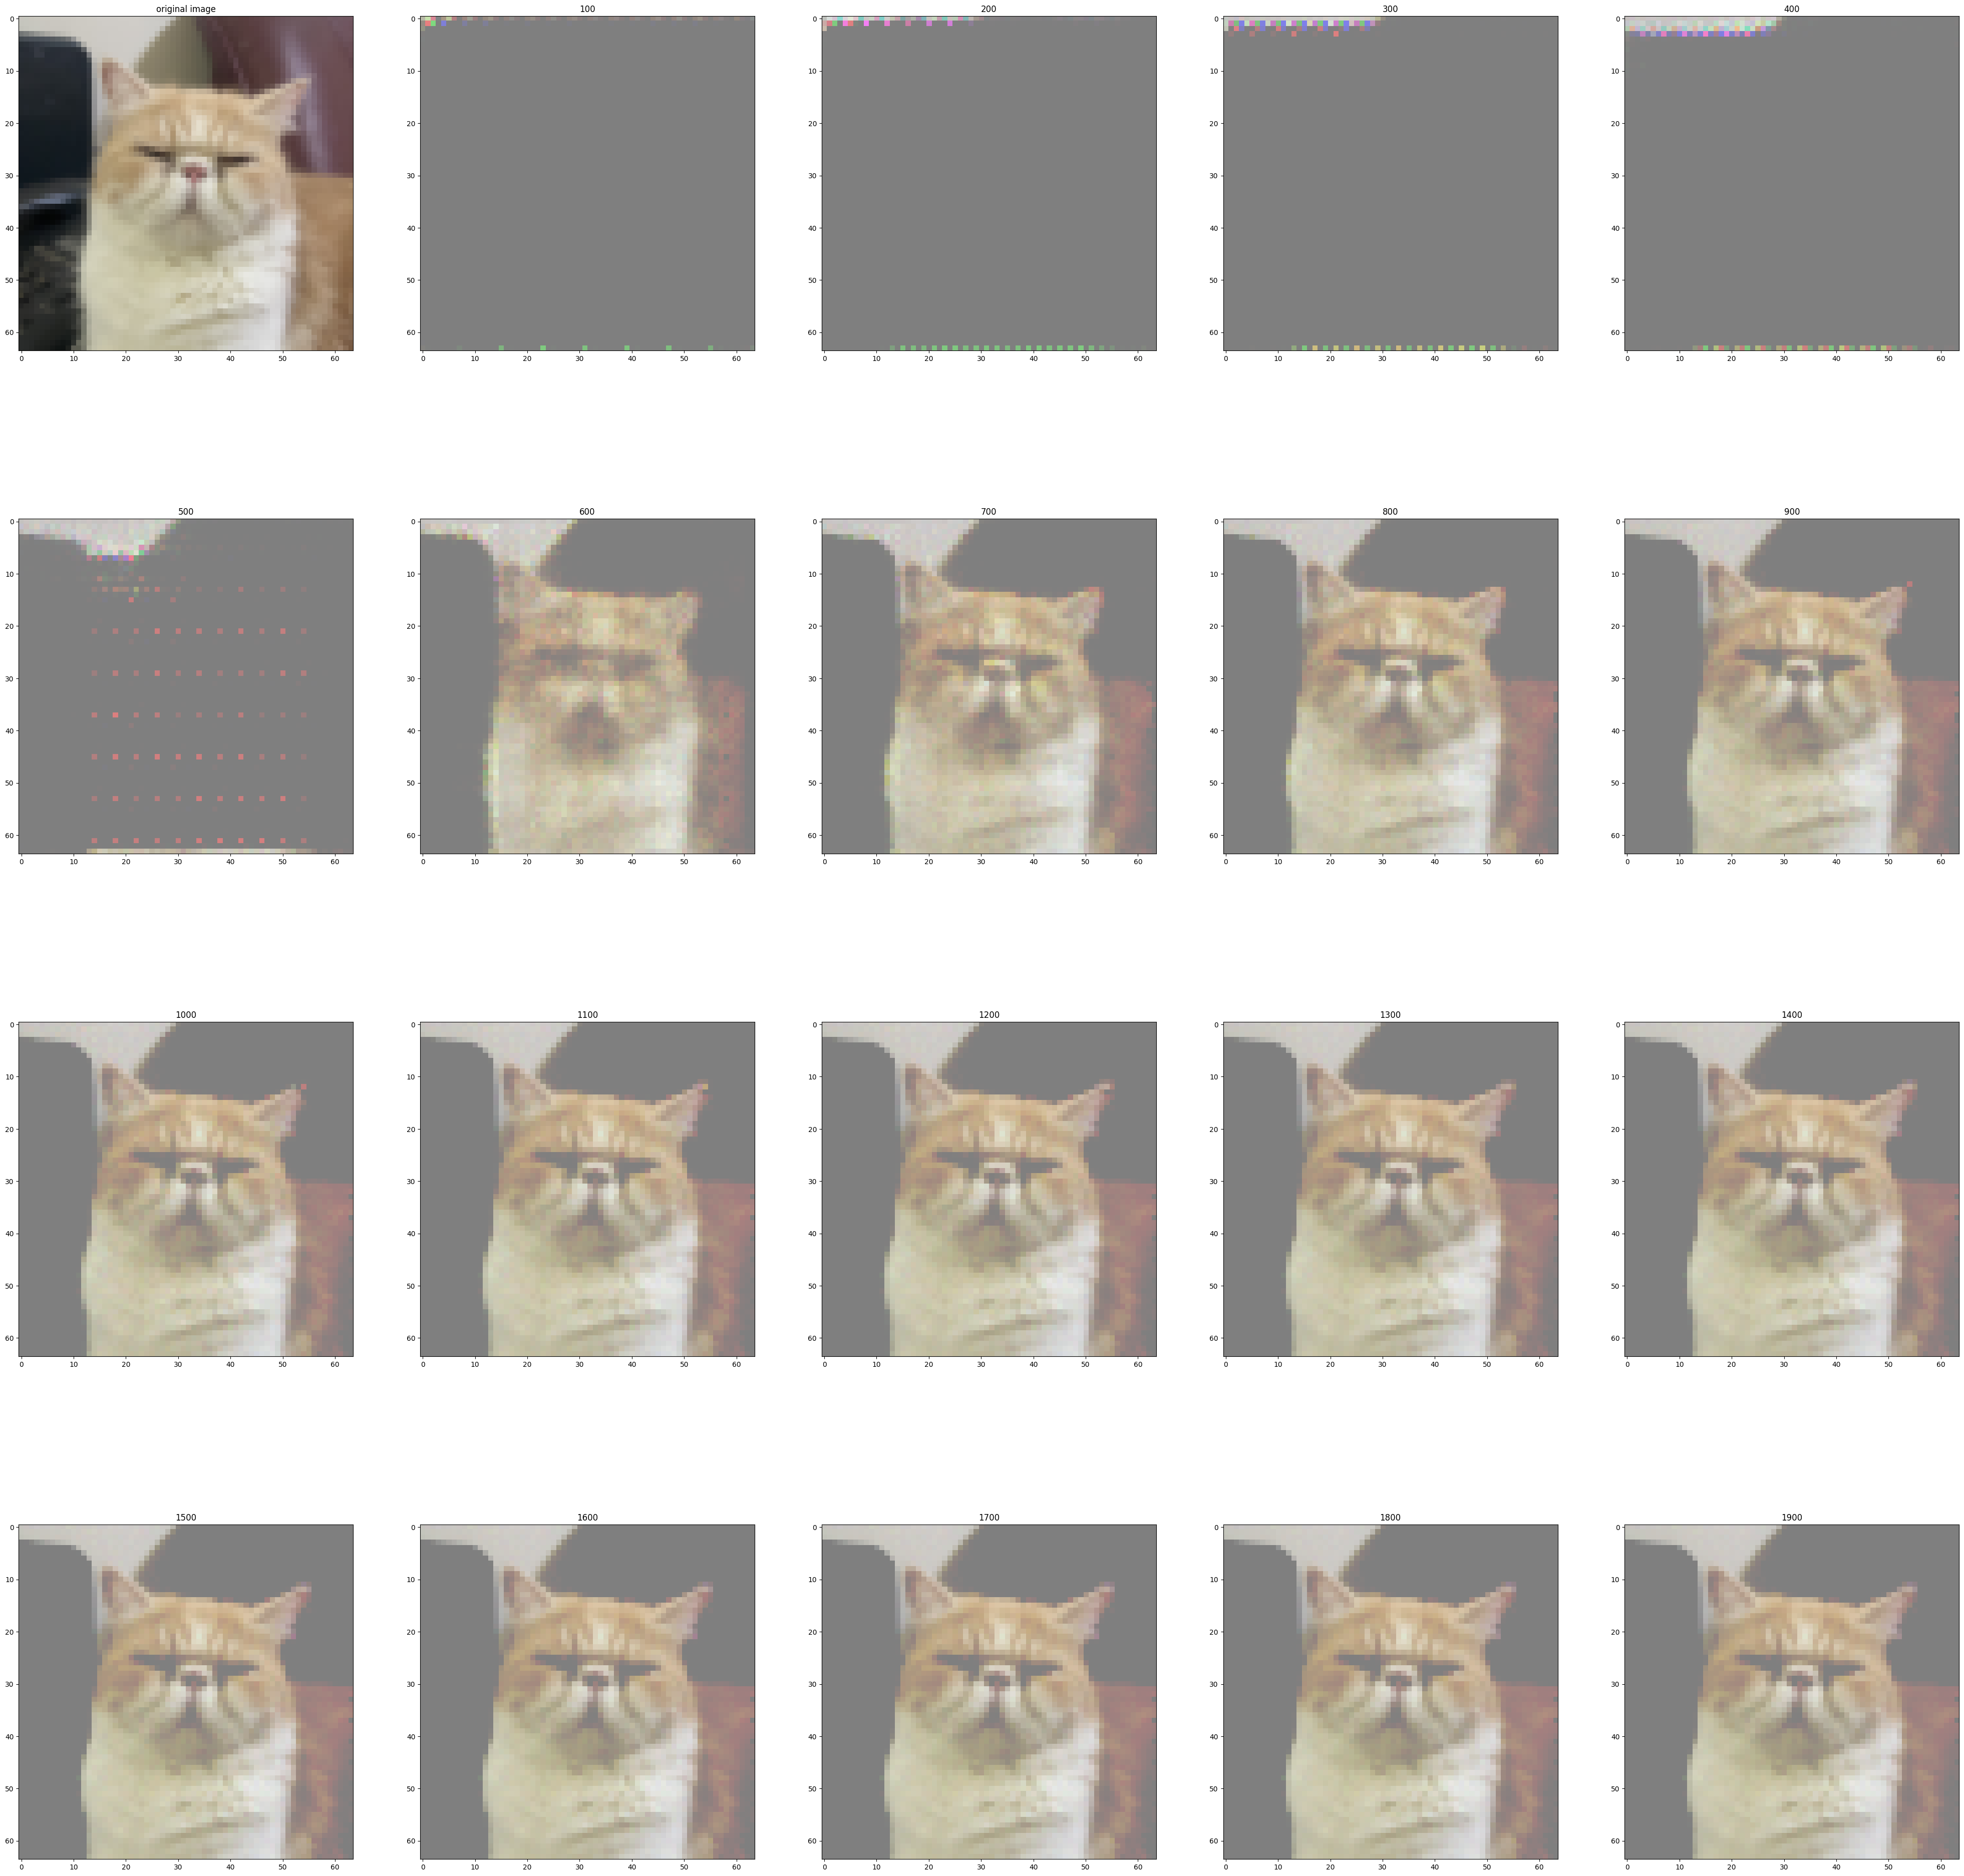

In [28]:
total = int(num_iterations / save_every)
plt.figure(figsize=(50,50))
for i in range(total):
    plt.subplot(4, 5, i+1)
    if (i==0):
        plt.title(f'original image')
        show_tensor_image(data)
    else:
        plt.title(f'{i * save_every}')
        show_tensor_image(result[i].detach().cpu())

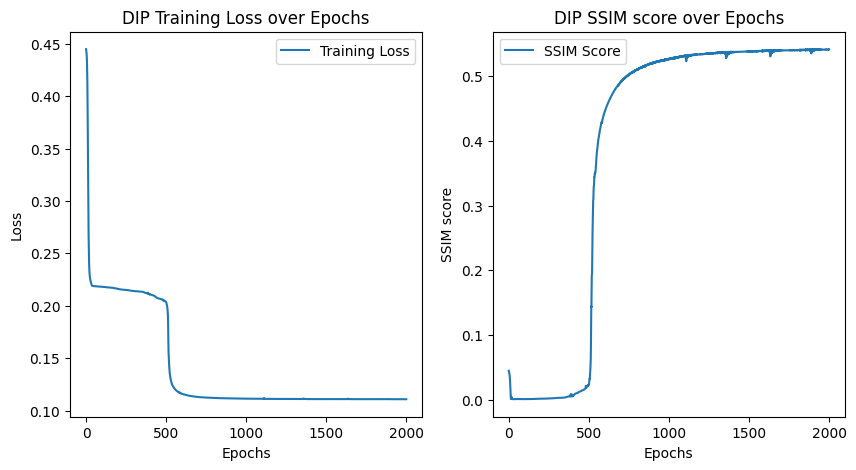

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DIP Training Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ssim_history, label="SSIM Score")
plt.xlabel("Epochs")
plt.ylabel("SSIM score")
plt.title("DIP SSIM score over Epochs")
plt.legend()
plt.show()